In [1]:
import os
import json
import csv
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
from statistics import pstdev
import pandas as pd

### Essential Dictionaries / lists

In [2]:
directory = 'densepose/txt'

#get directories without hidden files
directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
directories.sort()

#Setup dictionary to collect file names
all_file_names = {}

#Identify all file names
for d in directories:
    #get file names without hidden files
    files = [f for f in os.listdir(os.path.join(directory, d)) if os.path.isfile(os.path.join(directory, d, f))]
    files.sort()
    all_file_names[d] = files

In [3]:
#Count the number of videos in each video type
#Determined by checking last number string on each image and
#checking if it matches '0001'
num_videos = {}
first_img_indexes = {}

for d in directories:
    video_count = 0
    num_images = len(all_file_names[d])
    for i in range(num_images):
        if all_file_names[d][i].split('.')[0].split('_')[-1] == '0001':
            video_count += 1
    num_videos[d] = video_count

In [4]:
#Print out summary results
print(f"{'dance':<9} | {'Num Images':<10} | {'Num Videos':<9}")
print("-"*35)
for k,v in all_file_names.items():
    print(f'{k:<9} | {len(v):<10} | {num_videos[k]}')

dance     | Num Images | Num Videos
-----------------------------------
ballet    | 22410      | 89
break     | 25622      | 95
cha       | 28098      | 98
flamenco  | 24755      | 88
foxtrot   | 23738      | 79
jive      | 29100      | 106
latin     | 24460      | 90
pasodoble | 26607      | 98
quickstep | 24036      | 82
rumba     | 27262      | 94
samba     | 25807      | 96
square    | 27453      | 97
swing     | 26337      | 95
tango     | 24020      | 80
tap       | 28541      | 95
waltz     | 24380      | 80


In [5]:
# getting the names of videos and adding them to a dictionary under the dance style they belong to
# video_names = {key=DanceStyle : value=[VideoName0, VideoName1, etc.]}
video_names = {}
for d in directories:
    dance_names = []
    for x in all_file_names[d]:
        sliced_name = x[0:-9]
        if sliced_name not in dance_names:
            dance_names.append(sliced_name)
    video_names[d] = dance_names

In [6]:
# Validation: should return 89
print(len(video_names['ballet']))

89


### Function: Number of people in a frame

In [7]:
def person_count(file_name):
    '''Input a JSON file and get the number of people in each frame. '''
    f = open(file_name, "r")
    j = json.load(f)
    f.close

    people_count = len(j)

    return people_count

In [8]:
# Testing results, should return 5
peeps = person_count('densepose/txt/ballet/-5Yp-vToI2E_016_0001.json')
peeps

5

### Removing Frames with 0 People -- not applied to anything yet

In [54]:
# INSTEAD OF DELETING ALL THE FILES: can remove them from all_file_names (list of all - usable - frames)

# dict to keep track of how many frames we are "deleting"
deleted_frames = {d:[] for d in directories}

# new list of files without 0 people
nonzero_file_names = {}

for d in directories:
    file_list = []
    counter = 0
    for f in all_file_names[d]:
        file_path = os.path.join(directory, d, f)
        #print(file_path)
        person_cnt = person_count(file_path)
        if person_cnt < 1:
            #print('removed: ', f, ' at location:', d)
            counter += 1
            #print("deleted")
            #os.remove(file_path)
        else:
            file_list.append(counter)
    deleted_frames[d] = counter
    nonzero_file_names[d] = file_list

print('Deleted frames: ', deleted_frames, '\n')

Deleted frames:  {'ballet': 745, 'break': 297, 'cha': 103, 'flamenco': 1283, 'foxtrot': 189, 'jive': 37, 'latin': 520, 'pasodoble': 152, 'quickstep': 476, 'rumba': 53, 'samba': 63, 'square': 0, 'swing': 4, 'tango': 47, 'tap': 980, 'waltz': 12} 



In [55]:
# confirm we removed file names from all_file_names
for d in directories:
    print(d, len(all_file_names[d]), len(nonzero_file_names[d]))

ballet 22410 21665
break 25622 25325
cha 28098 27995
flamenco 24755 23472
foxtrot 23738 23549
jive 29100 29063
latin 24460 23940
pasodoble 26607 26455
quickstep 24036 23560
rumba 27262 27209
samba 25807 25744
square 27453 27453
swing 26337 26333
tango 24020 23973
tap 28541 27561
waltz 24380 24368


### Statistics for the Number of People per Video

In [9]:
# Making an all-inclusive dictionary to hold dance style, video name, and num people in each frame of video

# dictionary to store: {DanceStyle: {video_0: [ list of person_count for each frame in vid ], video_1: [ ... ], etc. }}
person_count_dict = {}

# looping through all dance styles
for d in directories:
    # dict to store avg number of people per video for 1 dance style
    style_dict = {}
    
    # looping through each video name
    for p in video_names[d]:
        # list to store num people for each frame for 1 video
        person_ct_list = []
        
        # looping through the files for the corresponding dance style to match the video title
        for f in all_file_names[d]:
            if f.startswith(p):
                file_path = os.path.join(directory, d, f)
                ct = person_count(file_path)
                person_ct_list.append(ct)

        
        style_dict[p] = person_ct_list
    person_count_dict[d] = style_dict

In [88]:
counter = 0
for name, ppl in person_count_dict['swing'].items():
    #print(ppl)
    c = ppl.count(2)
    #print('value being added to counter: ', c)
    counter += c
    #print('updated counter value: ', counter)

print(counter)

5289


In [29]:
def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

In [74]:
styles = []
avgs = []
mins = []
maxs = []
stdevs = []

# style = dance style (i.e. 'ballet')
# vid = dictionary of video names and list of length of each frame in video 
    # (i.e. {'-5Yp-vToI2E_016_': [5, 6, 6, 7, 6, 6, 6, 7, 6, 6, 5, 5....],... } 
for style, vid in person_count_dict.items():
    ppl = list(flatten(vid.values()))
    styles.append(style)
    # mean
    avg = int(mean(ppl))
    avgs.append(avg)
    # min
    ppl_array = np.array(ppl)
    minimum = np.min(ppl_array[np.nonzero(ppl_array)])
    mins.append(minimum)
    # max
    maximum = max(ppl)
    maxs.append(maximum)
    # standard deviation
    stdev = int(pstdev(person_ct_list))
    stdevs.append(stdev)

df_people = pd.DataFrame(list(zip(styles,avgs, mins, maxs, stdevs)), columns = ['dance','avg', 'min', 'max', 'stdev'])
df_people

,dance,avg,min,max,stdev
0,ballet,3,1,20,1
1,break,6,1,20,1
2,cha,8,1,20,1
3,flamenco,4,1,17,1
4,foxtrot,7,1,20,1
5,jive,7,1,20,1
6,latin,4,1,20,1
7,pasodoble,6,1,20,1
8,quickstep,6,1,20,1
9,rumba,8,1,20,1


### Avg Number of People per Frame per Dance Style

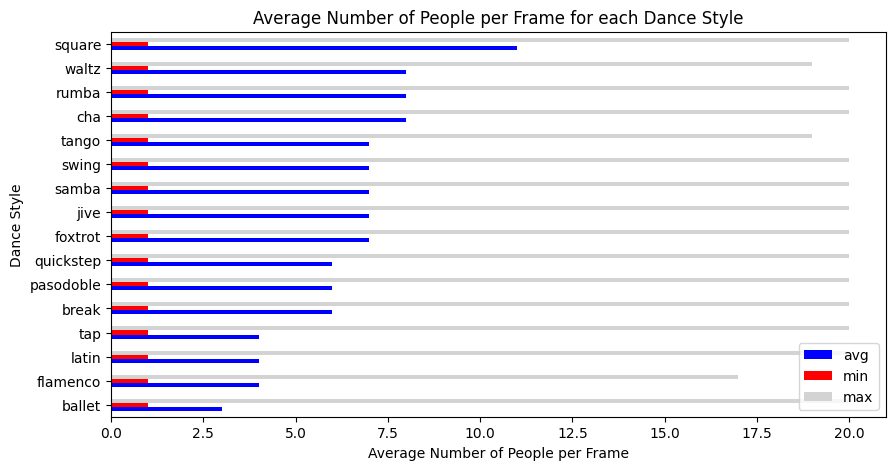

In [75]:
# Count the avg number of people per frame, per dance style
grouped_avg = df_people[['dance', 'avg', 'min', 'max']].groupby(['dance']).mean().sort_values('avg')

# plot
grouped_avg.plot.barh(figsize = (10, 5), color = {'avg':'blue', 'min':'red', 'max':'lightgrey'})

plt.xlabel('Average Number of People per Frame')
plt.ylabel('Dance Style')
plt.title('Average Number of People per Frame for each Dance Style')
plt.show()

### Histogram of People counts (by frame)

In [76]:
# Getting Number of people per frame

# dictionary to store number of people per frame
frame_person_count_dict = dict()

# looping through all dance styles
for d in directories:
    temp_styles = {}
    # looping through the files for the corresponding dance style to match the video title
    for f in all_file_names[d]:
        file_path = os.path.join(directory, d, f)
        ct = person_count(file_path)
        #frame_person_count_dict[f[:-5]] = ct
        temp_styles[f[:-5]] = ct
    frame_person_count_dict[d] = temp_styles

#frame_person_count_dict

In [77]:
df_frame = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in frame_person_count_dict.items()
    }, axis=0).reset_index().rename(columns={0: 'num_people', 'level_0': 'dance_style', 'level_1':'frame'})
df_frame.head()

,dance_style,frame,num_people
0,ballet,-5Yp-vToI2E_016_0001,5
1,ballet,-5Yp-vToI2E_016_0002,6
2,ballet,-5Yp-vToI2E_016_0003,6
3,ballet,-5Yp-vToI2E_016_0004,7
4,ballet,-5Yp-vToI2E_016_0005,6


In [78]:
grouped_frames = df_frame.groupby(['dance_style','num_people']).count() #.reset_index() #.rename(columns={'num'})
grouped_frames.head()

frame
dance_style num_people       
ballet      0             745
            1            8351
            2            3998
            3            2128
            4            1750

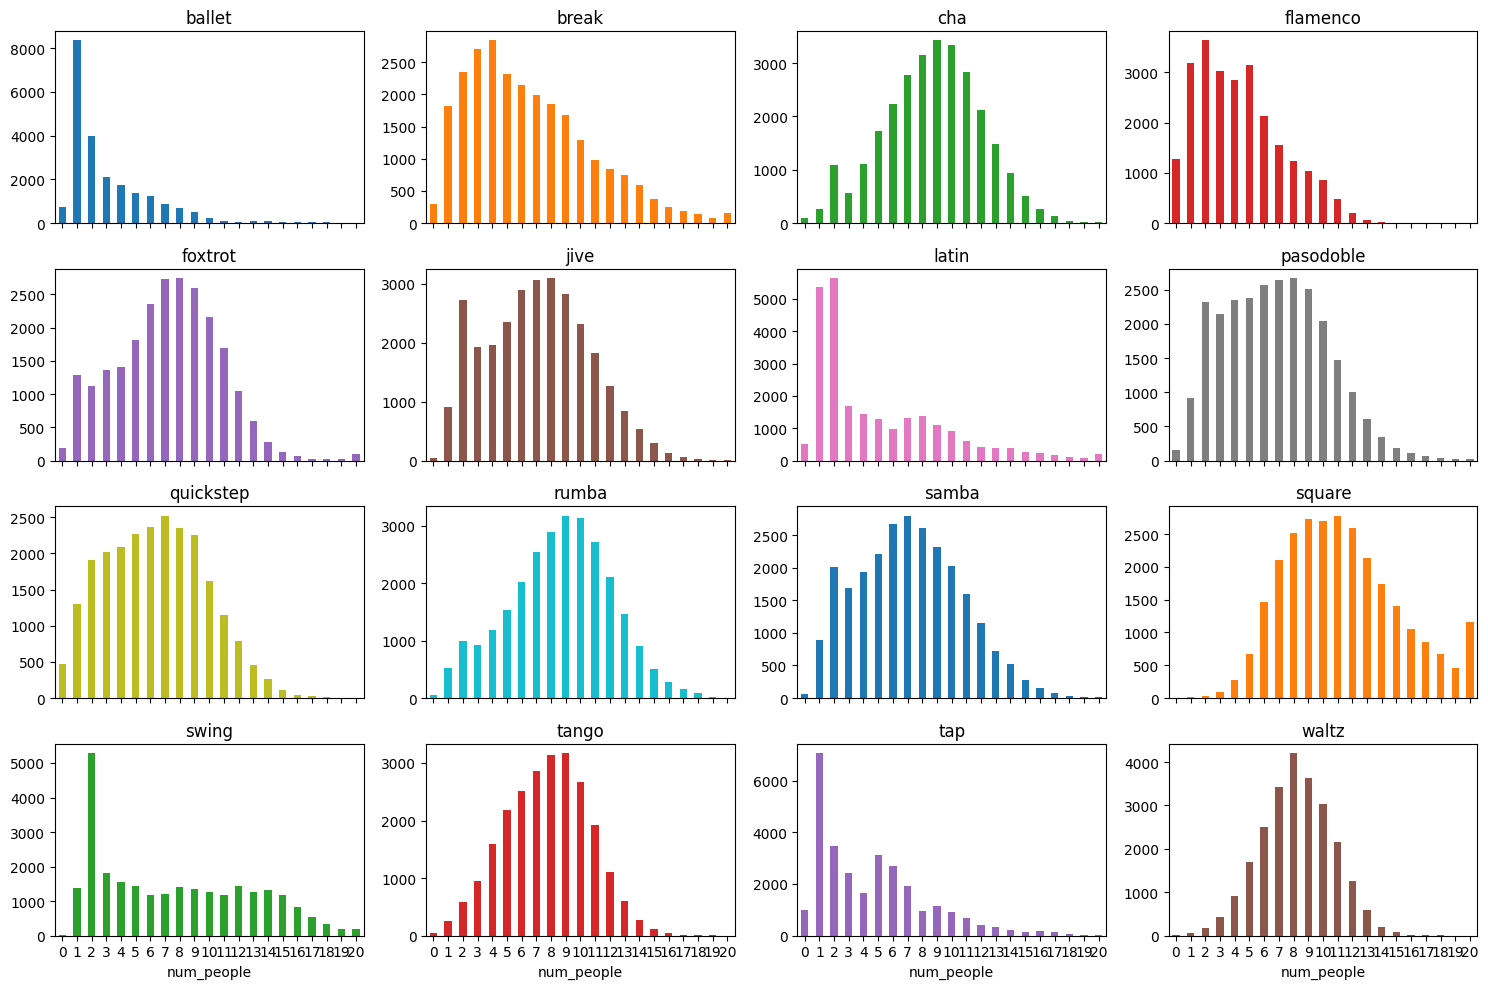

In [79]:
ax = grouped_frames.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(15, 10), layout= (4, 4), legend = False, 
                                         title = directories)
plt.tight_layout()